In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops

import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
import torch.nn as nn

from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from graphFeatureSelect.utils import get_adata
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold


custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [2]:
adata = get_adata("../data/VISp.h5ad")

# selecting 1 layer of anndata
# use supertype not subclass
display(adata.obs[["brain_section_label", "z_section"]].sort_values("z_section").value_counts().to_frame().head(4))
one_sec = adata[adata.obs["z_section"] == 5.0, :]
df = one_sec.obs.copy()
num_nodes = df.shape[0]
cell_type = "supertype"

# creating train/test masks
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep cells who are participants in the multilayer graph (more than 1 connection)
train_idx, test_idx = next(skf.split(np.arange(df.shape[0]), df[cell_type].values))

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(df.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

labels = torch.tensor(df[cell_type].cat.codes.values, dtype=torch.long)

# constructing edges with nearest neighbors
k = 10
X = df[["x_reconstructed", "y_reconstructed"]]

A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

edgelist_self = torch.tensor([[i, i] for i in range(num_nodes)])
edgelist_self = edgelist_self.T

one_sec_x = torch.tensor(one_sec.X.todense(), dtype=torch.float)
one_sec_x = one_sec_x[:, :10]  #  10 genes as input
one_sec_coord = torch.from_numpy(X.values).float()  # xy coords
# one_sec_x = torch.cat((one_sec_x, one_sec_coord), dim=1) # add xy coordinates to dataframe

data_knn = Data(
    x=one_sec_x, coords=one_sec_coord, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask
)
data_self = Data(
    x=one_sec_x, coords=one_sec_coord, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask
)

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939


/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [12]:
class GATConcrete(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, n_mask):
        super().__init__()
        torch.manual_seed(1234567)
        self.concrete = nn.Parameter(torch.randn(n_mask, num_features))
        self.hidden_channels = hidden_channels
        self.conv1 = GATv2Conv(num_features + 2, hidden_channels, heads=8, concat=False)
        self.conv2 = GATv2Conv(hidden_channels, num_classes, heads=8, concat=False)
        self.lin1 = nn.Linear(num_features + 2, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x, coords, edge_index, temp, hard_):
        # randomly swap coords - randomly select n edge_index pairs and swap their coords
        idx_to_swap = np.random.choice(edge_index.shape[1], 1000)
        for i in idx_to_swap:
            a = edge_index[0][i]
            b = edge_index[1][i]
            coord_ = coords[a]
            coords[a][0] = coords[b][0]
            coords[a][1] = coords[b][1]
            coords[b][0] = coord_[0]
            coords[b][1] = coord_[1]

        mask = F.gumbel_softmax(self.concrete, tau=temp, hard=hard_)
        mask = torch.sum(mask, axis=0)
        mask = torch.clamp(mask, min=0, max=1)
        x = mask * x
        x = torch.cat((x, coords), dim=1)
        residual1 = self.lin1(x)

        out = self.conv1(x, edge_index)
        out = out.relu()
        out = self.dropout(out)

        out = self.conv2(out, edge_index)
        out = out + residual1

        return out

In [13]:
def exp_decay_temp_schedule(epoch, total_epoch):
    start_temp = 10
    end_temp = 0.01
    temp = start_temp * (end_temp / start_temp) ** (epoch / total_epoch)
    return temp


def train_gnn(model, optimizer, data, criterion, epoch, num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(
        data.x, data.coords, data.edge_index, exp_decay_temp_schedule(epoch, num_epochs), False
    )  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss


def test_gnn(model, data):
    model.eval()
    out = model(data.x, data.coords, data.edge_index, 0.01, True)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


def training_loop(model, data, total_epoch, learning_rate):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn(model, optimizer_self, data, criterion, epoch, total_epoch)
        val_acc = test_gnn(model, data)
        if epoch % 100 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

Epoch: 100, Loss: 2.3929, Val acc: 0.0768
Epoch: 200, Loss: 2.0708, Val acc: 0.2580
Epoch: 300, Loss: 2.0427, Val acc: 0.2975
Epoch: 400, Loss: 1.8771, Val acc: 0.1239
Epoch: 500, Loss: 1.8088, Val acc: 0.3786
Epoch: 600, Loss: 1.8515, Val acc: 0.1741
Epoch: 700, Loss: 1.8790, Val acc: 0.1428
Epoch: 800, Loss: 2.0438, Val acc: 0.4246
Epoch: 900, Loss: 1.8820, Val acc: 0.4235
Epoch: 1000, Loss: 1.8541, Val acc: 0.4083
Epoch: 1100, Loss: 1.9825, Val acc: 0.3797
Epoch: 1200, Loss: 1.9208, Val acc: 0.4100
Epoch: 1300, Loss: 1.8634, Val acc: 0.4310
Epoch: 1400, Loss: 1.9042, Val acc: 0.4381
Epoch: 1500, Loss: 1.8423, Val acc: 0.4273
Epoch: 1600, Loss: 1.9255, Val acc: 0.4094
Epoch: 1700, Loss: 1.8290, Val acc: 0.3981
Epoch: 1800, Loss: 1.8537, Val acc: 0.4300
Epoch: 1900, Loss: 1.8547, Val acc: 0.4511
Epoch: 2000, Loss: 1.8357, Val acc: 0.4375
Model accuracy: 0.4094


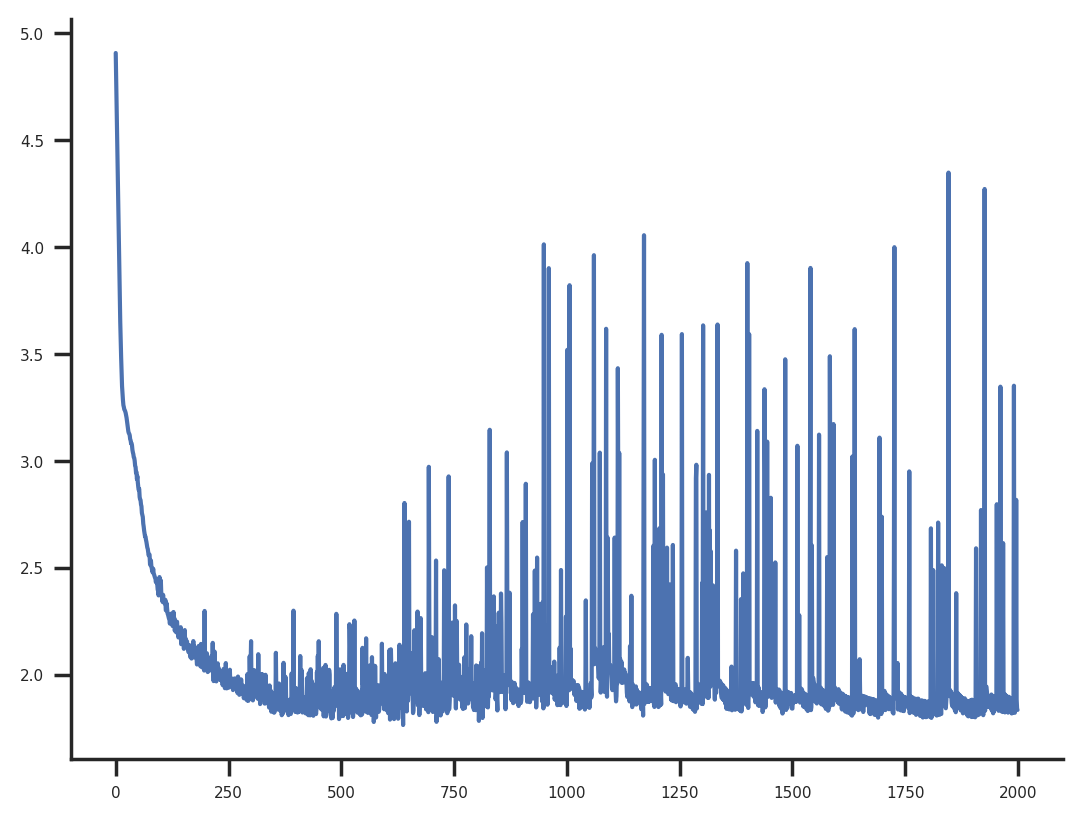

In [14]:
# lr = 0.005 with coord swaps
learning_rate = 0.005
GAT_conc = GATConcrete(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0], n_mask=3
)
val_acc, loss_list = training_loop(GAT_conc, data_knn, 2000, learning_rate)
plt.plot(loss_list)

Epoch: 100, Loss: 3.1525, Val acc: 0.1568
Epoch: 200, Loss: 2.7471, Val acc: 0.2396
Epoch: 300, Loss: 2.5958, Val acc: 0.2693
Epoch: 400, Loss: 2.4329, Val acc: 0.1790
Epoch: 500, Loss: 2.3097, Val acc: 0.1585
Epoch: 600, Loss: 2.2304, Val acc: 0.2374
Epoch: 700, Loss: 2.1925, Val acc: 0.1677
Epoch: 800, Loss: 2.5155, Val acc: 0.3483
Epoch: 900, Loss: 2.4369, Val acc: 0.3240
Epoch: 1000, Loss: 2.1704, Val acc: 0.3186
Epoch: 1100, Loss: 2.2008, Val acc: 0.2591
Epoch: 1200, Loss: 2.3384, Val acc: 0.3326
Epoch: 1300, Loss: 2.2196, Val acc: 0.3488
Epoch: 1400, Loss: 2.1565, Val acc: 0.3515
Epoch: 1500, Loss: 3.9059, Val acc: 0.3661
Epoch: 1600, Loss: 2.1172, Val acc: 0.3753
Epoch: 1700, Loss: 2.1326, Val acc: 0.3559
Epoch: 1800, Loss: 3.1571, Val acc: 0.3559
Epoch: 1900, Loss: 2.3199, Val acc: 0.3288
Epoch: 2000, Loss: 2.0570, Val acc: 0.3564
Model accuracy: 0.3824


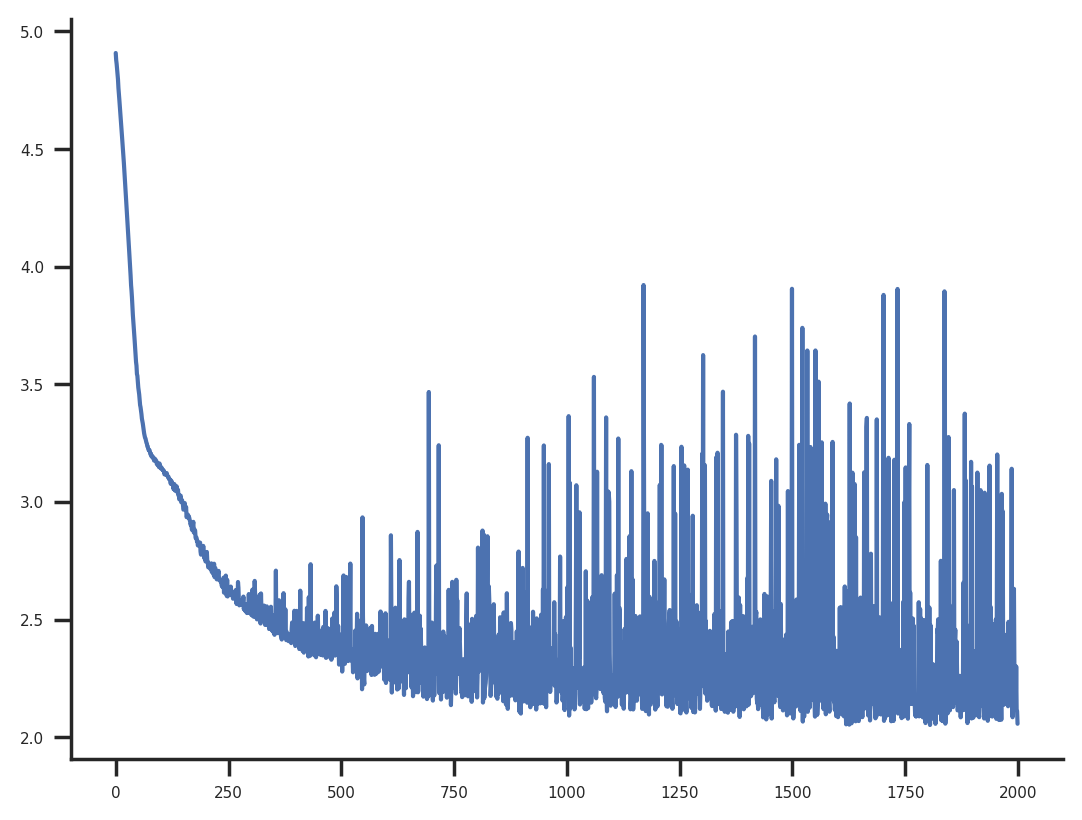

In [ ]:
# lr = 0.001
learning_rate = 0.001
GAT_conc = GATConcrete(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0], n_mask=3
)
val_acc, loss_list = training_loop(GAT_conc, data_knn, 2000, learning_rate)
plt.plot(loss_list)

Epoch: 100, Loss: 2.3880, Val acc: 0.0757
Epoch: 200, Loss: 2.0655, Val acc: 0.2547
Epoch: 300, Loss: 2.0358, Val acc: 0.2969
Epoch: 400, Loss: 1.8743, Val acc: 0.1217
Epoch: 500, Loss: 1.8048, Val acc: 0.3824
Epoch: 600, Loss: 1.8463, Val acc: 0.1812
Epoch: 700, Loss: 1.8749, Val acc: 0.1498
Epoch: 800, Loss: 2.0383, Val acc: 0.4251
Epoch: 900, Loss: 1.8777, Val acc: 0.4202
Epoch: 1000, Loss: 1.8495, Val acc: 0.4105
Epoch: 1100, Loss: 1.9783, Val acc: 0.3916
Epoch: 1200, Loss: 1.9127, Val acc: 0.4127
Epoch: 1300, Loss: 1.8591, Val acc: 0.4278
Epoch: 1400, Loss: 1.8990, Val acc: 0.4402
Epoch: 1500, Loss: 1.8351, Val acc: 0.4224
Epoch: 1600, Loss: 1.9192, Val acc: 0.4154
Epoch: 1700, Loss: 1.8262, Val acc: 0.3986
Epoch: 1800, Loss: 1.8493, Val acc: 0.4332
Epoch: 1900, Loss: 1.8500, Val acc: 0.4527
Epoch: 2000, Loss: 1.8290, Val acc: 0.4511
Model accuracy: 0.4246


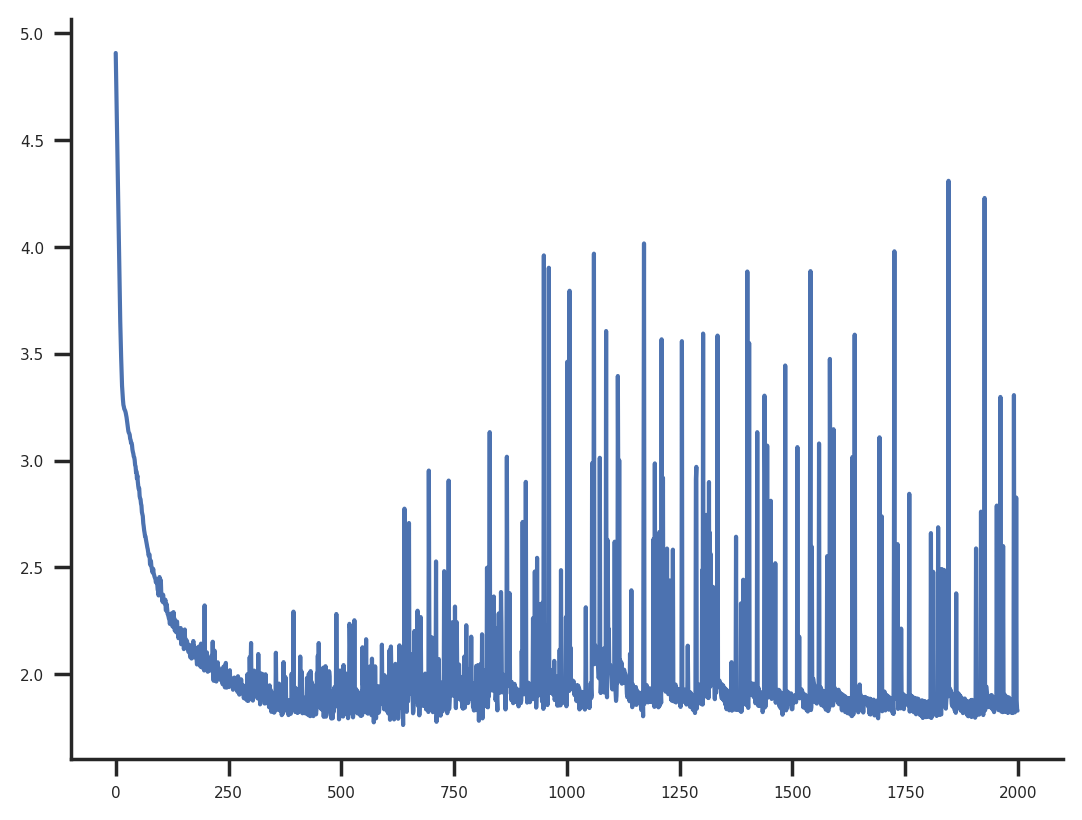

In [57]:
# lr = 0.005
learning_rate = 0.005
GAT_conc = GATConcrete(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0], n_mask=3
)
val_acc, loss_list = training_loop(GAT_conc, data_knn, 2000, learning_rate)
plt.plot(loss_list)

Epoch: 100, Loss: 2.0876, Val acc: 0.0552
Epoch: 200, Loss: 1.8942, Val acc: 0.2239
Epoch: 300, Loss: 1.8566, Val acc: 0.2699
Epoch: 400, Loss: 1.7868, Val acc: 0.1141
Epoch: 500, Loss: 1.7501, Val acc: 0.3883
Epoch: 600, Loss: 1.8167, Val acc: 0.1725
Epoch: 700, Loss: 1.8340, Val acc: 0.1228
Epoch: 800, Loss: 1.9312, Val acc: 0.4202
Epoch: 900, Loss: 1.8452, Val acc: 0.4267
Epoch: 1000, Loss: 1.7958, Val acc: 0.4159
Epoch: 1100, Loss: 1.9299, Val acc: 0.4224
Epoch: 1200, Loss: 1.8183, Val acc: 0.4267
Epoch: 1300, Loss: 1.7682, Val acc: 0.4348
Epoch: 1400, Loss: 1.7772, Val acc: 0.4429
Epoch: 1500, Loss: 1.8040, Val acc: 0.3926
Epoch: 1600, Loss: 1.7805, Val acc: 0.4127
Epoch: 1700, Loss: 1.7559, Val acc: 0.4067
Epoch: 1800, Loss: 1.8618, Val acc: 0.4554
Epoch: 1900, Loss: 1.7499, Val acc: 0.4516
Epoch: 2000, Loss: 1.8145, Val acc: 0.4170
Model accuracy: 0.4170


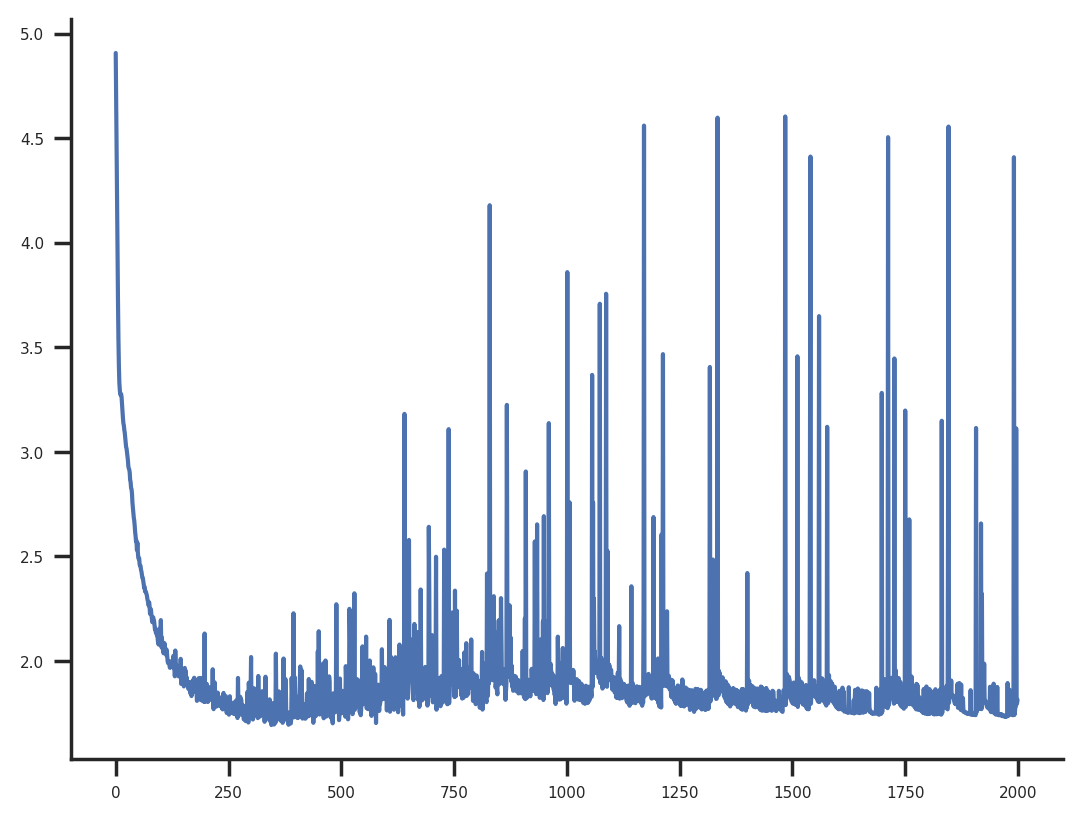

In [58]:
# lr = 0.01
learning_rate = 0.01
GAT_conc = GATConcrete(
    hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0], n_mask=3
)
val_acc, loss_list = training_loop(GAT_conc, data_knn, 2000, learning_rate)
plt.plot(loss_list)

In [50]:
# MLP classifier to predict celltypes (baseline)
from sklearn.neural_network import MLPClassifier

baseline_x = torch.cat((one_sec_x, one_sec_coord), dim=1)
clf = MLPClassifier()
clf.fit(baseline_x[train_mask], labels[train_mask])

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [51]:
np.round(clf.score(baseline_x[test_mask], labels[test_mask]), 2)

np.float64(0.45)